In [21]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from sklearn.model_selection import train_test_split


In [3]:
tf.__version__


'2.19.0'

In [4]:
#load Dataset
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.cifar100.load_data()

In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

In [6]:
import numpy as np

print("y_train shape:", y_train.shape)
print("num classes:", len(np.unique(y_train)))
print("min/max label:", y_train.min(), y_train.max())

y_train shape: (40000, 1)
num classes: 100
min/max label: 0 99


In [7]:
# Convert NumPy arrays into a tf.data pipeline (yields (image, label) pairs)

ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
ds_val = tf.data.Dataset.from_tensor_slices((X_val, y_val))
ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [8]:
# Data augmentation
def data_augment(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_hue(image, max_delta=0.5)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)

    image = tf.clip_by_value(image, 0.0, 1.0)
    image = image * 255.0

    return image, label

In [9]:
IMG_SIZE = 240
def preprocessing(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = preprocess_input(image)
    label = tf.squeeze(label, axis=-1)
    return image, label

In [10]:
# prepare pipline
def prepare_pip(ds, augment=False, shuffle=False):
    ds = ds.shuffle(10000) if shuffle else ds
    ds = ds.map(data_augment, num_parallel_calls=tf.data.AUTOTUNE) if augment else ds
    ds = ds.map(preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(128)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [11]:
# Preprocess the data
# Preprocess the data
train_ds = prepare_pip(ds_train, augment=True, shuffle=True)
val_ds = prepare_pip(ds_val, augment=False, shuffle=False)
test_ds = prepare_pip(ds_test, augment=False, shuffle=False)

## Implement *"efficientnet_v2"* using transfer Learning

In [12]:

input_shape = (240, 240, 3)

base_model = tf.keras.applications.EfficientNetV2B0(include_top=False, weights='imagenet',input_shape=input_shape,pooling='avg')

base_model.trainable = False

model = tf.keras.Sequential(
    [
    tf.keras.layers.Input(shape=input_shape),
    base_model,
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(256, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,272,948 (23.93 MB)

 Trainable params: 353,636 (1.35 MB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [13]:
reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.2, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(
    monitor="val_accuracy", patience=8, restore_best_weights=True
)
callbacks = [early_stopping, reduce_lr]


In [14]:
# Train the model
history = model.fit(train_ds, epochs=100,callbacks=callbacks, validation_data=val_ds)

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 124s 287ms/step - accuracy: 0.2542 - loss: 3.2506 - val_accuracy: 0.6169 - val_loss: 1.3885 - learning_rate: 0.0010
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 52s 167ms/step - accuracy: 0.4833 - loss: 1.9334 - val_accuracy: 0.6480 - val_loss: 1.2477 - learning_rate: 0.0010
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 51s 164ms/step - accuracy: 0.5279 - loss: 1.7346 - val_accuracy: 0.6680 - val_loss: 1.1659 - learning_rate: 0.0010
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 52s 164ms/step - accuracy: 0.5458 - loss: 1.6541 - val_accuracy: 0.6785 - val_loss: 1.1224 - learning_rate: 0.0010
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 56s 179ms/step - accuracy: 0.5607 - loss: 1.5867 - val_accuracy: 0.6900 - val_loss: 1.0900 - learning_rate: 0.0010
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 51s 164ms/step - accuracy: 0.5673 - loss: 1.5471 - val_accuracy: 0.6851 - val_loss: 1.0871 - learning_rate: 0.0010
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 52s 165ms/step - accur

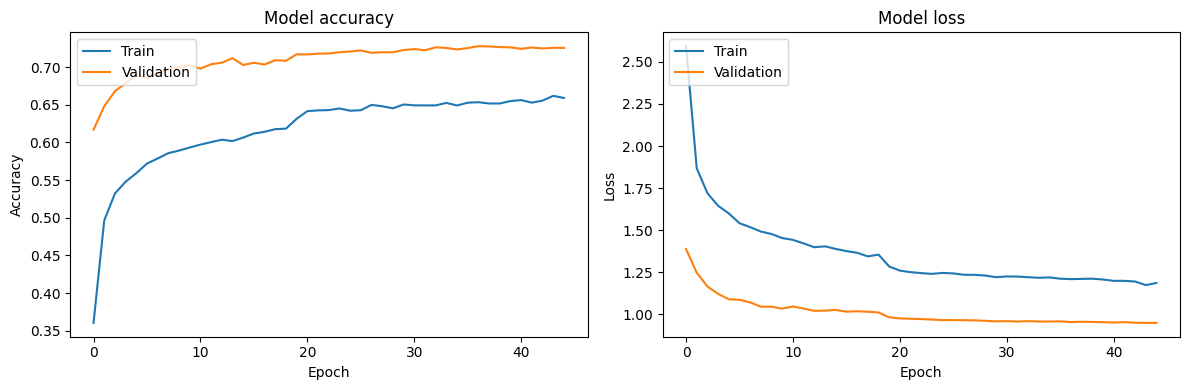

In [15]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# fine-tuning

In [27]:
initial_epoch = history.epoch[-1] + 1

In [36]:
import math

#open the basic model's lock(EfficientNet)
base_model.trainable = True

#!important: Batch Normalization must be freezed
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

#frezing first layers(jusr last 30 layers is open)
N_LAST = 30
fine_tune_at = max(0, len(base_model.layers) - N_LAST)
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# new section: CosineDecay

#extract the num of stops in every epochs(this is necessary to adjust the wavelengths)
steps_per_epoch = len(train_ds)

#definision of sin waves
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
     # a normal shock for RUN from hole
    initial_learning_rate=5e-5,
     # length of first Wave with e.q 4 epoch
    first_decay_steps=steps_per_epoch * 4,
     # nex waves have double Stretch e.q 8,16
    t_mul=2.0,
     #after every restart wave crest decresed 20% for change slowly
    m_mul=0.8,
     # min val of LR that wave can have in wave botom
    alpha=1e-2
)

# ۵. Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

# Control with "CosineDecay"
callbacks_fine = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=12,
        restore_best_weights=True
    )
]

# Fine-tuning phase
fine_tune_epochs = 55
total_epochs = initial_epoch + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=initial_epoch,
    validation_data=val_ds,
    callbacks=callbacks_fine
)

Epoch 46/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 149s 374ms/step - accuracy: 0.7400 - loss: 0.8677 - val_accuracy: 0.7641 - val_loss: 0.8050
Epoch 47/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 61s 195ms/step - accuracy: 0.7415 - loss: 0.8607 - val_accuracy: 0.7642 - val_loss: 0.8021
Epoch 48/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 60s 191ms/step - accuracy: 0.7430 - loss: 0.8479 - val_accuracy: 0.7640 - val_loss: 0.8009
Epoch 49/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 61s 194ms/step - accuracy: 0.7486 - loss: 0.8457 - val_accuracy: 0.7638 - val_loss: 0.8011
Epoch 50/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 61s 193ms/step - accuracy: 0.7436 - loss: 0.8577 - val_accuracy: 0.7645 - val_loss: 0.7991
Epoch 51/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 194ms/step - accuracy: 0.7456 - loss: 0.8377 - val_accuracy: 0.7629 - val_loss: 0.7990
Epoch 52/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 70s 225ms/step - accuracy: 0.7484 - loss: 0.8418 - val_accuracy: 0.7634 - val_loss: 0.7981
Epoch 53/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 59s 187ms/step - accuracy:

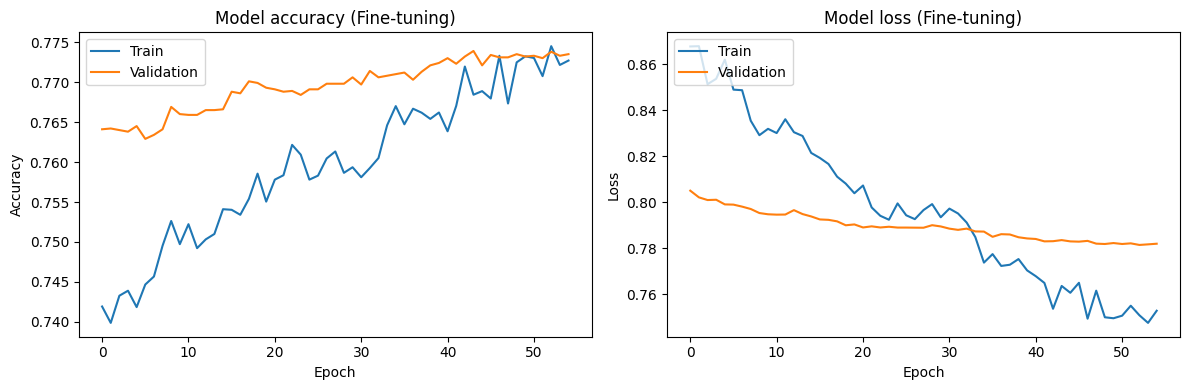

In [38]:
# Plot training & validation accuracy values (Fine-tuning)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.title('Model accuracy (Fine-tuning)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values (Fine-tuning)
plt.subplot(1, 2, 2)
plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('Model loss (Fine-tuning)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()